In [7]:
import os

# Define dataset root path
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN"

# Define processed image paths
processed_folder = os.path.join(dataset_path, "Processed_Images")
image_folder = os.path.join(processed_folder, "images")
mask_folder = os.path.join(processed_folder, "masks")

# ✅ Create necessary directories if they don’t exist
os.makedirs(processed_folder, exist_ok=True)
os.makedirs(image_folder, exist_ok=True)
os.makedirs(mask_folder, exist_ok=True)

# ✅ Verify dataset structure
folders = ["TRAIN", "VAL", "TEST"]
for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.exists(folder_path):
        print(f"✅ Found: {folder}")
    else:
        print(f"❌ Missing: {folder}")

print("✅ Dataset structure verified. Now ready for image processing!")


✅ Found: TRAIN
✅ Found: VAL
✅ Found: TEST
✅ Dataset structure verified. Now ready for image processing!


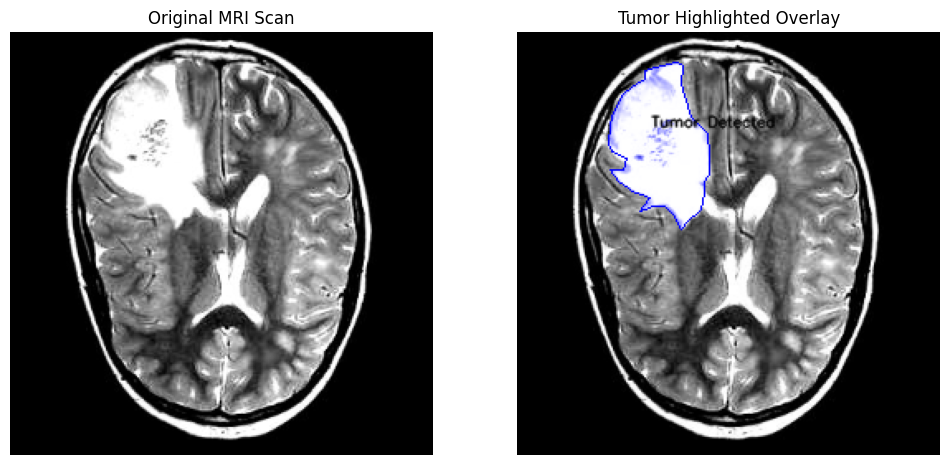

In [17]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ✅ Path to dataset and annotation file
annotation_file = os.path.join(dataset_path, "annotations_all.json")

# ✅ Load annotation data
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# ✅ Define a sample image
sample_image_name = "y0.jpg"  
sample_image_path = os.path.join(dataset_path, "TRAIN", sample_image_name)

# ✅ Load the original image without resizing
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
if sample_image is None:
    raise ValueError(f"Image {sample_image_name} not found or unable to load!")

original_size = sample_image.shape[:2]  # Get original image size (height, width)

# ✅ Normalize image for better visualization
sample_image = cv2.normalize(sample_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# ✅ Extract annotation key from JSON (Find closest match)
matching_key = next((key for key in annotations.keys() if sample_image_name in key), None)
if not matching_key:
    raise ValueError(f"No matching annotation found for {sample_image_name}!")

sample_annotation = annotations[matching_key]  # Get corresponding annotation data

# ✅ Function to resize while maintaining aspect ratio
def resize_with_padding(image, target_size=(256, 256)):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)

    resized = cv2.resize(image, (new_w, new_h))
    padded = np.zeros((target_h, target_w), dtype=np.uint8)

    pad_x = (target_w - new_w) // 2
    pad_y = (target_h - new_h) // 2

    padded[pad_y:pad_y+new_h, pad_x:pad_x+new_w] = resized

    return padded, scale, pad_x, pad_y

# ✅ Resize sample image with aspect ratio preserved
resized_sample_image, scale, pad_x, pad_y = resize_with_padding(sample_image, (256, 256))

# ✅ Function to create mask using resized image
def create_mask_from_annotation(annotation, original_size, scale, pad_x, pad_y):
    h_orig, w_orig = original_size
    mask = np.zeros((256, 256), dtype=np.uint8)
    contour_list = []

    for region in annotation["regions"]:
        shape_attr = region["shape_attributes"]
        if shape_attr["name"] == "polygon":
            all_x = (np.array(shape_attr["all_points_x"]) * scale + pad_x).astype(int)
            all_y = (np.array(shape_attr["all_points_y"]) * scale + pad_y).astype(int)

            contour = np.array(list(zip(all_x, all_y)), dtype=np.int32)
            contour_list.append(contour)

            cv2.fillPoly(mask, [contour], 255)

    return mask, contour_list

# ✅ Generate mask with resized image dimensions
sample_mask, contours = create_mask_from_annotation(sample_annotation, original_size, scale, pad_x, pad_y)

# ✅ Convert grayscale to 3-channel for overlaying
overlay_image = cv2.cvtColor(resized_sample_image, cv2.COLOR_GRAY2BGR)
colored_mask = np.zeros_like(overlay_image)
colored_mask[:, :, 2] = sample_mask  

# ✅ Blend overlay with original image
overlayed_image = cv2.addWeighted(overlay_image, 1, colored_mask, 0.6, 0)

# ✅ Draw tumor boundary
cv2.polylines(overlayed_image, contours, isClosed=True, color=(0, 0, 255), thickness=1)
if len(contours) > 0:
    M = cv2.moments(contours[0])
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(overlayed_image, "Tumor Detected", (cX - 5, cY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

# ✅ Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(resized_sample_image, cmap="gray")
plt.title("Original MRI Scan")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlayed_image)
plt.title("Tumor Highlighted Overlay")
plt.axis("off")

plt.show()


Processing All Images (Original + Overlayed)

In [22]:
import os
import numpy as np
import cv2
import json
from tensorflow.keras.preprocessing.image import save_img

# ✅ Define dataset directories
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN"
processed_folder = os.path.join(dataset_path, "Processed_Images")
original_folder = os.path.join(processed_folder, "original")
overlay_folder = os.path.join(processed_folder, "overlay")

# ✅ Create folders if they don’t exist
os.makedirs(original_folder, exist_ok=True)
os.makedirs(overlay_folder, exist_ok=True)

# ✅ Load annotation JSON
annotation_file = os.path.join(dataset_path, "annotations_all.json")

with open(annotation_file, "r") as f:
    annotations = json.load(f)

# ✅ Overlay Parameters
alpha = 0.6  # Transparency level for overlay

# ✅ Function to create mask from annotation
def create_mask_from_annotation(annotation, original_size):
    h_orig, w_orig = original_size  # Preserve original dimensions
    mask = np.zeros((h_orig, w_orig), dtype=np.uint8)
    contour_list = []

    for region in annotation["regions"]:
        shape_attr = region["shape_attributes"]
        
        if shape_attr["name"] == "polygon":
            all_x = np.array(shape_attr["all_points_x"])
            all_y = np.array(shape_attr["all_points_y"])

            # Ensure coordinates stay within the image bounds
            all_x = np.clip(all_x, 0, w_orig - 1)
            all_y = np.clip(all_y, 0, h_orig - 1)

            # Convert to contour format
            contour = np.array(list(zip(all_x, all_y)), dtype=np.int32)
            contour_list.append(contour)

            # Draw the tumor mask
            cv2.fillPoly(mask, [contour], 255)

    return mask, contour_list

# ✅ Process all images from TRAIN, TEST, and VAL folders
for folder in ["TRAIN", "TEST", "VAL"]:
    folder_path = os.path.join(dataset_path, folder)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # ✅ Check if it's a valid image
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        # ✅ Load the original image without resizing
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Skipping {img_name}, unable to read.")
            continue

        original_size = img.shape[:2]  # Store original height & width

        # ✅ Save original image (preserving aspect ratio)
        save_img(os.path.join(original_folder, img_name), np.expand_dims(img, axis=-1))

        # ✅ Extract base filename for lookup in JSON
        base_filename = os.path.splitext(img_name)[0]  
        matching_key = next((key for key in annotations.keys() if base_filename in key), None)

        if matching_key:
            mask, contours = create_mask_from_annotation(annotations[matching_key], original_size)

            # ✅ Convert grayscale image to 3-channel for overlaying
            img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            # ✅ Create an overlay mask
            colored_mask = np.zeros_like(img_color)
            colored_mask[:, :, 2] = mask  # Apply mask in **Red** channel

            # ✅ Blend overlay with the original image
            overlayed_image = cv2.addWeighted(img_color, 1, colored_mask, alpha, 0)

            # ✅ Draw tumor boundary in **Blue**
            cv2.polylines(overlayed_image, contours, isClosed=True, color=(0, 0, 255), thickness=2)

            # ✅ Add label near the tumor
            if len(contours) > 0:
                M = cv2.moments(contours[0])
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    cv2.putText(overlayed_image, "Tumor Detected", (cX - 5, cY - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

            # ✅ Save overlay image
            save_img(os.path.join(overlay_folder, img_name), overlayed_image)

print(f"✅ All original images saved in: {original_folder}")
print(f"✅ All overlay images saved in: {overlay_folder}")
    

✅ All original images saved in: C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\original
✅ All overlay images saved in: C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\overlay


Resize Both Image and Overlay Without Misalignment

In [23]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import save_img

# ✅ Define dataset directories
processed_folder = os.path.join(dataset_path, "Processed_Images")
original_folder = os.path.join(processed_folder, "original")
overlay_folder = os.path.join(processed_folder, "overlay")
final_original_folder = os.path.join(processed_folder, "final_original")
final_overlay_folder = os.path.join(processed_folder, "final_overlay")

# ✅ Create necessary directories
os.makedirs(final_original_folder, exist_ok=True)
os.makedirs(final_overlay_folder, exist_ok=True)

# ✅ Target size (256x256) - Ensuring consistency
target_size = (256, 256)

# ✅ Function to resize both images while preserving alignment
def resize_pair(image, overlay, target_size):
    image_resized = cv2.resize(image, target_size)
    overlay_resized = cv2.resize(overlay, target_size)
    return image_resized, overlay_resized

# ✅ Process all images in the original and overlay folders
for img_name in os.listdir(original_folder):
    img_path = os.path.join(original_folder, img_name)
    overlay_path = os.path.join(overlay_folder, img_name)

    # ✅ Load images
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    overlay = cv2.imread(overlay_path, cv2.IMREAD_COLOR)

    if img is None or overlay is None:
        print(f"⚠️ Skipping {img_name}, unable to read.")
        continue

    # ✅ Resize both images together
    img_resized, overlay_resized = resize_pair(img, overlay, target_size)

    # ✅ Save resized images
    save_img(os.path.join(final_original_folder, img_name), np.expand_dims(img_resized, axis=-1))
    save_img(os.path.join(final_overlay_folder, img_name), overlay_resized)

print(f"✅ All resized original images saved in: {final_original_folder}")
print(f"✅ All resized overlay images saved in: {final_overlay_folder}")


✅ All resized original images saved in: C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\final_original
✅ All resized overlay images saved in: C:\Users\Suraj Yadav\FinalProjectTY\datasetMRI\Br35H-Mask-RCNN\Processed_Images\final_overlay
